In [ ]:
# ==============================
# Download PR commit details for AIDev-POP (Colab)
# ==============================

!pip install -q huggingface_hub pyarrow pandas

from huggingface_hub import hf_hub_download
import pandas as pd

# 1) Download the full PR commit details table from the AIDev dataset (Hugging Face)
local_parquet_path = hf_hub_download(
    repo_id="hao-li/AIDev",
    filename="pr_commit_details.parquet",
    repo_type="dataset",
)

print("Downloaded Parquet file to:", local_parquet_path)

# 2) Load commit details into pandas
commit_df = pd.read_parquet(local_parquet_path)
print("Commit details shape (all PRs):", commit_df.shape)

# 3) Load your AIDev-POP >=500-star PR subset
#    Make sure you've uploaded 'aidev_pop_ge500_agent_prs.csv' to Colab first
aprs = pd.read_csv("aidev_pop_ge500_agent_prs.csv")
print("AIDev-POP APRs shape:", aprs.shape)
print("Columns in AIDev-POP APRs:", aprs.columns.tolist())

# 4) Ensure the PR id column is named 'pr_id' to match the AIDev commit table
#    (In many AIDev tables, PR id is 'id'; adjust if needed)
if "pr_id" not in aprs.columns:
    if "id" in aprs.columns:
        aprs = aprs.rename(columns={"id": "pr_id"})
    else:
        raise ValueError("Could not find 'pr_id' or 'id' column in the AIDev-POP CSV.")

# Keep only the PR id column for joining (deduplicate to avoid exploding rows)
aprs_ids = aprs[["pr_id"]].drop_duplicates()

# 5) Filter commit details to only PRs that belong to AIDev-POP
aidev_pop_commit_df = commit_df.merge(aprs_ids, on="pr_id", how="inner")
print("AIDev-POP commit details shape:", aidev_pop_commit_df.shape)

# 6) (Optional) Save to CSV for later analysis
aidev_pop_commit_df.to_csv("aidev_pop_pr_commit_details.csv", index=False)
print("Saved filtered commit details to 'aidev_pop_pr_commit_details.csv'.")

# Quick peek
aidev_pop_commit_df.head()


Downloaded Parquet file to: /root/.cache/huggingface/hub/datasets--hao-li--AIDev/snapshots/eee0408a277826d88fc0ca5fa07d2fc325c96af1/pr_commit_details.parquet
Commit details shape (all PRs): (711923, 14)
AIDev-POP APRs shape: (12433, 22)
Columns in AIDev-POP APRs: ['agent_type', 'agent', 'id', 'number', 'title', 'repo_id', 'full_name', 'language', 'stars', 'forks', 'url', 'user', 'user_id', 'created_at', 'closed_at', 'merged_at', 'turnaround_time_hours', 'state', 'pr_outcome', 'body', 'html_url', 'repo_url']
AIDev-POP commit details shape: (399039, 14)
Saved filtered commit details to 'aidev_pop_pr_commit_details.csv'.


,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,.github/workflows/compile-llms-txt.yml,added,38.0,0.0,38.0,"@@ -0,0 +1,38 @@\n+name: Compile llms.txt\n+\n..."
1,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im..."
2,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,llms.txt,added,22923.0,0.0,22923.0,None
3,dbd1b5f129f7cffa5ce284d7255814c98bcc38a2,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Fix lint issues: remove unused variable and ap...,35,18,17,docs/compile_llms_txt.py,modified,18.0,17.0,35.0,"@@ -1,47 +1,48 @@\n import os\n from pathlib i..."
4,c2659cfdedf666c8f14753d71664563c2a932b23,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Update llms.txt to follow official standard wi...,23035,89,22946,docs/compile_llms_txt.py,modified,51.0,36.0,87.0,"@@ -3,45 +3,60 @@\n \n \n def compile_llms_txt..."


In [ ]:
# ======================================================
# FIRST ANALYSIS ON PR COMMIT DETAILS FOR AIDEV-POP
# Goal: see whether PR size / tests / docs can explain
#       the drop in rejection over time
# ======================================================

!pip install -q pandas pyarrow statsmodels

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# ------------------------------------------------------
# 1. Load data (adjust filenames here if needed)
# ------------------------------------------------------

# Commit-level details for AIDev-POP ≥500 repos
commit_df = pd.read_csv("aidev_pop_pr_commit_details.csv")

# PR-level metadata with outcome, created_at_pr, agent_type, task_type, etc.
pr_df = pd.read_csv("aidev_pop_ge500_pr_review_comments_with_task_type.csv")

print("Commit-level shape:", commit_df.shape)
print("PR-level shape:", pr_df.shape)
print("PR-level columns:", pr_df.columns.tolist())
print("Commit-level columns:", commit_df.columns.tolist())

# ------------------------------------------------------
# 2. Make sure PR key matches on both sides
#    (in most AIDev tables it's 'pr_id'; adjust if needed)
# ------------------------------------------------------

# If your PR-level file uses something like 'id' as PR ID:
if "pr_id" not in pr_df.columns:
    if "id" in pr_df.columns:
        pr_df = pr_df.rename(columns={"id": "pr_id"})
    else:
        raise ValueError("Could not find 'pr_id' or 'id' in PR-level file.")

if "pr_id" not in commit_df.columns:
    if "id" in commit_df.columns:
        commit_df = commit_df.rename(columns={"id": "pr_id"})
    else:
        raise ValueError("Could not find 'pr_id' or 'id' in commit-level file.")

# Drop any obvious duplicate (commit_df should already be commit-level)
commit_df = commit_df.dropna(subset=["pr_id"])
pr_df = pr_df.dropna(subset=["pr_id"])

# ------------------------------------------------------
# 3. Aggregate commit details to one row per PR
#    Features: n_commits, n_files, size, tests/docs touched
# ------------------------------------------------------

# For test / doc flags we just use filename patterns as a first approximation
def count_matches(series, pattern):
    return series.str.contains(pattern, case=False, na=False).sum()

agg = (
    commit_df
    .groupby("pr_id")
    .agg(
        n_commits       = ("sha", "nunique"),             # how many distinct commits
        n_files         = ("filename", "nunique"),        # how many distinct files
        total_additions = ("additions", "sum"),
        total_deletions = ("deletions", "sum"),
        total_changes   = ("changes", "sum"),
        n_test_files    = ("filename", lambda s: count_matches(s, "test")),
        n_doc_files     = ("filename", lambda s: count_matches(s, r"docs|readme|\.md")),
    )
    .reset_index()
)

print("Per-PR aggregate shape:", agg.shape)
print(agg.head())

# Simple boolean flags
agg["touched_tests"] = (agg["n_test_files"] > 0).astype(int)
agg["touched_docs"]  = (agg["n_doc_files"]  > 0).astype(int)

# ------------------------------------------------------
# 4. Merge with PR-level metadata (outcome, created_at, agent_type, task_type)
# ------------------------------------------------------

# Keep only columns we need from PR-level table
keep_cols = [
    "pr_id",
    "pr_outcome",       # REJECTED / MERGED / OPEN
    "created_at_pr",    # PR creation datetime
    "agent_type",
    "task_type",
]

for c in keep_cols:
    if c not in pr_df.columns:
        print(f"WARNING: '{c}' not found in PR-level file")

pr_meta = pr_df[[c for c in keep_cols if c in pr_df.columns]].drop_duplicates("pr_id")

merged = agg.merge(pr_meta, on="pr_id", how="inner")
print("Merged per-PR dataset shape:", merged.shape)
print(merged.head())

# ------------------------------------------------------
# 5. Time features: parse created_at_pr and build month_index
# ------------------------------------------------------

merged["created_at_pr"] = pd.to_datetime(merged["created_at_pr"], errors="coerce")
merged = merged.dropna(subset=["created_at_pr"])

# Year-month string, e.g., '2024-12'
merged["year_month"] = merged["created_at_pr"].dt.to_period("M").astype(str)

# Month index: 0 for earliest month, 1 for next, etc.
month_order = (
    merged["year_month"]
    .sort_values()
    .unique()
)
month_to_idx = {m: i for i, m in enumerate(month_order)}
merged["month_index"] = merged["year_month"].map(month_to_idx)

print("Month mapping:", month_to_idx)

# ------------------------------------------------------
# 6. Define rejection label & restrict to closed PRs only
# ------------------------------------------------------

# Closed PRs = MERGED or REJECTED (adjust if naming differs)
closed_mask = merged["pr_outcome"].isin(["MERGED", "REJECTED"])
closed = merged[closed_mask].copy()

closed["rejected"] = (closed["pr_outcome"] == "REJECTED").astype(int)

print("Closed PRs:", closed.shape)
print(closed["pr_outcome"].value_counts())

# ------------------------------------------------------
# 7. Descriptive stats: size + tests/docs vs outcome
# ------------------------------------------------------

print("\n=== Descriptive stats by outcome ===")
print(
    closed
    .groupby("pr_outcome")[["total_changes", "n_files", "n_commits"]]
    .describe(percentiles=[0.5])  # includes median
)

print("\n=== Tests/docs touch rate by outcome ===")
print(
    closed
    .groupby("pr_outcome")[["touched_tests", "touched_docs"]]
    .mean()
)

print("\n=== Average size & tests/docs BY MONTH and outcome ===")
by_month_outcome = (
    closed
    .groupby(["year_month", "pr_outcome"])
    .agg(
        n_prs          = ("pr_id", "nunique"),
        mean_changes   = ("total_changes", "mean"),
        median_changes = ("total_changes", "median"),
        mean_files     = ("n_files", "mean"),
        mean_commits   = ("n_commits", "mean"),
        test_rate      = ("touched_tests", "mean"),
        doc_rate       = ("touched_docs", "mean"),
    )
    .reset_index()
)

print(by_month_outcome.sort_values(["year_month", "pr_outcome"]))

# ------------------------------------------------------
# 8. First logistic regression:
#    rejected ~ month_index + log1p(total_changes) + touched_tests + touched_docs
# ------------------------------------------------------

# Avoid issues with zero size
closed["log_total_changes"] = np.log1p(closed["total_changes"].fillna(0))

# We can also drop rows with missing predictors just in case
model_data = closed.dropna(subset=["month_index", "log_total_changes"])

print("\n=== Logistic regression: rejected ~ month_index + size + tests/docs ===")
logit_model = smf.logit(
    "rejected ~ month_index + log_total_changes + touched_tests + touched_docs",
    data=model_data
).fit(disp=False)

print(logit_model.summary())

# Odds ratios for interpretability
odds_ratios = np.exp(logit_model.params)
print("\nOdds ratios:")
print(odds_ratios)


Commit-level shape: (399039, 14)
PR-level shape: (18383, 40)
PR-level columns: ['id_comment', 'pull_request_review_id', 'user_comment', 'user_type', 'diff_hunk', 'path', 'position', 'original_position', 'commit_id', 'original_commit_id', 'body_comment', 'pull_request_url', 'created_at_comment', 'updated_at', 'in_reply_to_id', 'id_review', 'pr_id', 'task_type', 'agent_type', 'agent', 'id_pr', 'number', 'title', 'repo_id', 'full_name', 'language', 'stars', 'forks', 'url', 'user_pr', 'user_id', 'created_at_pr', 'closed_at', 'merged_at', 'turnaround_time_hours', 'state', 'pr_outcome', 'body_pr', 'html_url', 'repo_url']
Commit-level columns: ['sha', 'pr_id', 'author', 'committer', 'message', 'commit_stats_total', 'commit_stats_additions', 'commit_stats_deletions', 'filename', 'status', 'additions', 'deletions', 'changes', 'patch']
Per-PR aggregate shape: (12353, 8)
        pr_id  n_commits  n_files  total_additions  total_deletions  \
0  2756921963         16       15            848.0      

/tmp/ipython-input-3125254831.py:112: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  merged["year_month"] = merged["created_at_pr"].dt.to_period("M").astype(str)


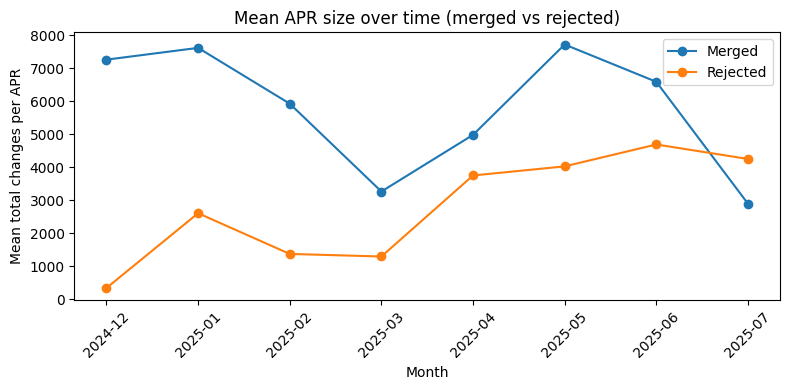

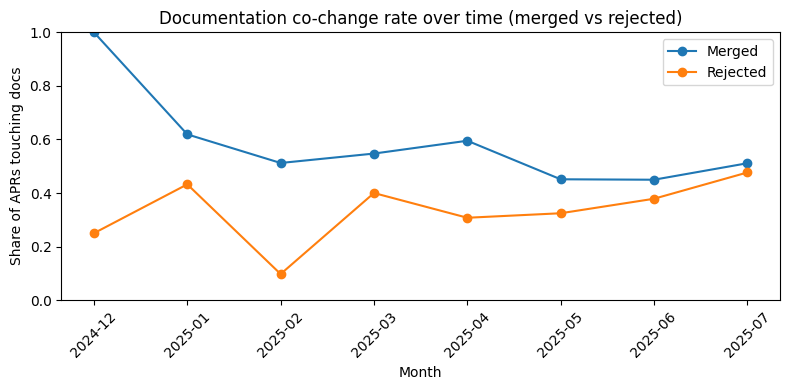

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure by_month_outcome exists (from the earlier code)
by_month_outcome = (
    closed
    .groupby(["year_month", "pr_outcome"])
    .agg(
        n_prs          = ("pr_id", "nunique"),
        mean_changes   = ("total_changes", "mean"),
        median_changes = ("total_changes", "median"),
        mean_files     = ("n_files", "mean"),
        mean_commits   = ("n_commits", "mean"),
        test_rate      = ("touched_tests", "mean"),
        doc_rate       = ("touched_docs", "mean"),
    )
    .reset_index()
)

# Order months
month_order = sorted(by_month_outcome["year_month"].unique())
by_month_outcome["year_month"] = pd.Categorical(
    by_month_outcome["year_month"],
    categories=month_order,
    ordered=True
)

# 1) Mean total_changes by month and outcome
plt.figure(figsize=(8, 4))
for outcome, label in [("MERGED", "Merged"), ("REJECTED", "Rejected")]:
    subset = by_month_outcome[by_month_outcome["pr_outcome"] == outcome]
    plt.plot(subset["year_month"], subset["mean_changes"], marker="o", label=label)

plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Mean total changes per APR")
plt.title("Mean APR size over time (merged vs rejected)")
plt.legend()
plt.tight_layout()
plt.savefig("commit_size_trend.pdf")  # or .png

# 2) Doc touch rate by month and outcome
plt.figure(figsize=(8, 4))
for outcome, label in [("MERGED", "Merged"), ("REJECTED", "Rejected")]:
    subset = by_month_outcome[by_month_outcome["pr_outcome"] == outcome]
    plt.plot(subset["year_month"], subset["doc_rate"], marker="o", label=label)

plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Share of APRs touching docs")
plt.title("Documentation co-change rate over time (merged vs rejected)")
plt.ylim(0.0, 1.0)
plt.legend()
plt.tight_layout()
plt.savefig("doc_touch_trend.pdf")


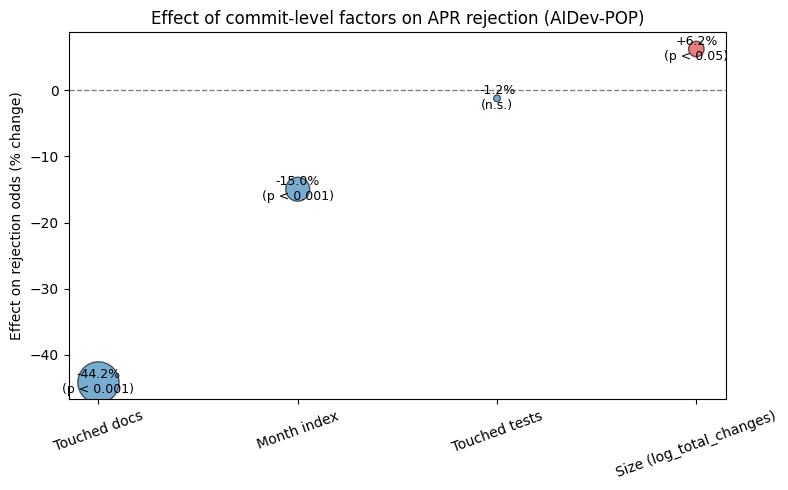

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1. Manually define the factors
#    (numbers from your logit model)
# ------------------------------
data = [
    {
        "factor": "Month index",
        "or": 0.850378,    # odds ratio
        "p": 0.0000,       # approx
    },
    {
        "factor": "Size (log_total_changes)",
        "or": 1.062302,
        "p": 0.0180,
    },
    {
        "factor": "Touched tests",
        "or": 0.987775,
        "p": 0.9060,
    },
    {
        "factor": "Touched docs",
        "or": 0.558336,
        "p": 0.0000,
    },
]

df = pd.DataFrame(data)

# ------------------------------
# 2. Compute effect (% change in odds) and bubble size
# ------------------------------
df["effect_pct"] = (df["or"] - 1.0) * 100.0   # % change in odds
df["abs_effect_pct"] = df["effect_pct"].abs()

# Map significance to a category string for labeling
def sig_label(p):
    if p < 0.001:
        return "p < 0.001"
    elif p < 0.01:
        return "p < 0.01"
    elif p < 0.05:
        return "p < 0.05"
    else:
        return "n.s."

df["sig"] = df["p"].apply(sig_label)

# Bubble area scale factor (tune this for better aesthetics)
scale = 20.0
df["bubble_size"] = df["abs_effect_pct"] * scale

# Sort factors for plotting order (optional)
df = df.sort_values("effect_pct")

# ------------------------------
# 3. Make the bubble plot
# ------------------------------
plt.figure(figsize=(8, 5))

x = np.arange(len(df))
y = df["effect_pct"]

# Color code by direction: risk vs protective
colors = ["tab:red" if v > 0 else "tab:blue" for v in y]

scatter = plt.scatter(
    x,
    y,
    s=df["bubble_size"],
    c=colors,
    alpha=0.6,
    edgecolors="black",
    linewidths=1.0,
)

plt.axhline(0, color="gray", linestyle="--", linewidth=1)

plt.xticks(x, df["factor"], rotation=20)
plt.ylabel("Effect on rejection odds (% change)")
plt.title("Effect of commit-level factors on APR rejection (AIDev-POP)")

# Add text labels with % and p-values
for i, row in df.iterrows():
    label = f"{row['effect_pct']:+.1f}%\n({row['sig']})"
    plt.text(
        x[list(df.index).index(i)],
        row["effect_pct"],
        label,
        ha="center",
        va="center",
        fontsize=9,
    )

plt.tight_layout()
plt.savefig("factor_effect_bubbles.pdf")   # or .png
plt.show()


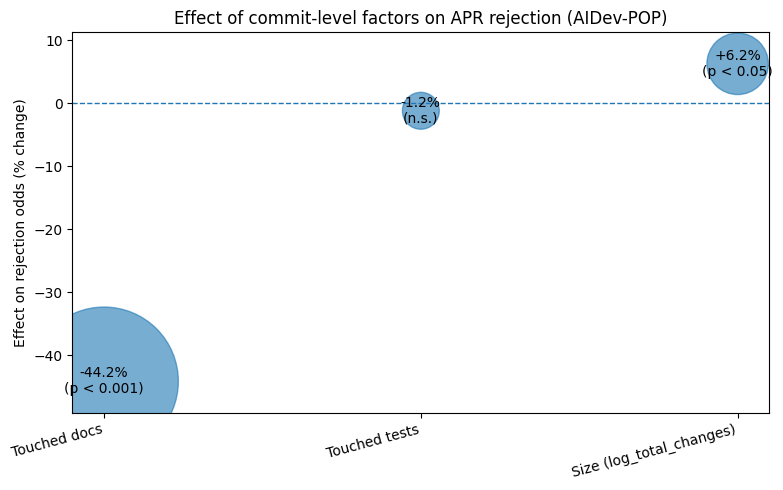

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define the factors from your model
#    (commit-level only: size, docs, tests)
# ------------------------------
data = [
    {
        "factor": "Size (log_total_changes)",
        "or": 1.062302,
        "p": 0.0180,
    },
    {
        "factor": "Touched tests",
        "or": 0.987775,
        "p": 0.9060,
    },
    {
        "factor": "Touched docs",
        "or": 0.558336,
        "p": 0.0000,
    },
]

df = pd.DataFrame(data)

# ------------------------------
# 2. Compute effect (% change in odds) and bubble size
# ------------------------------
df["effect_pct"] = (df["or"] - 1.0) * 100.0     # +/- % change in odds
df["abs_effect_pct"] = df["effect_pct"].abs()

# Map significance label
def sig_label(p):
    if p < 0.001:
        return "p < 0.001"
    elif p < 0.01:
        return "p < 0.01"
    elif p < 0.05:
        return "p < 0.05"
    else:
        return "n.s."

df["sig"] = df["p"].apply(sig_label)

# Make bubbles bigger and ensure a minimum size
scale = 250.0          # increase this to make all bubbles larger
min_size = 400.0       # minimum bubble area so even tiny effects are visible
df["bubble_size"] = df["abs_effect_pct"] * scale + min_size

# Sort by effect for nicer ordering
df = df.sort_values("effect_pct").reset_index(drop=True)

# ------------------------------
# 3. Create the bubble plot
# ------------------------------
plt.figure(figsize=(8, 5))

x = np.arange(len(df))
y = df["effect_pct"]

# Scatter without specifying colors (use defaults)
plt.scatter(
    x,
    y,
    s=df["bubble_size"],
    alpha=0.6,
    linewidths=1.0,
)

# Reference line at 0% effect
plt.axhline(0, linestyle="--", linewidth=1)

plt.xticks(x, df["factor"], rotation=15, ha="right")
plt.ylabel("Effect on rejection odds (% change)")
plt.title("Effect of commit-level factors on APR rejection (AIDev-POP)")

# Add labels with +/-% and significance inside/near bubbles
for i, row in df.iterrows():
    label = f"{row['effect_pct']:+.1f}%\n({row['sig']})"
    plt.text(
        i,
        row["effect_pct"],
        label,
        ha="center",
        va="center",
        fontsize=10,
    )

# Make y-limits a bit padded
y_min = min(y.min(), -5) - 5
y_max = max(y.max(), 5) + 5
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.savefig("factor_effect_bubbles_big.pdf")  # or .png
plt.show()


/tmp/ipython-input-3587962337.py:115: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


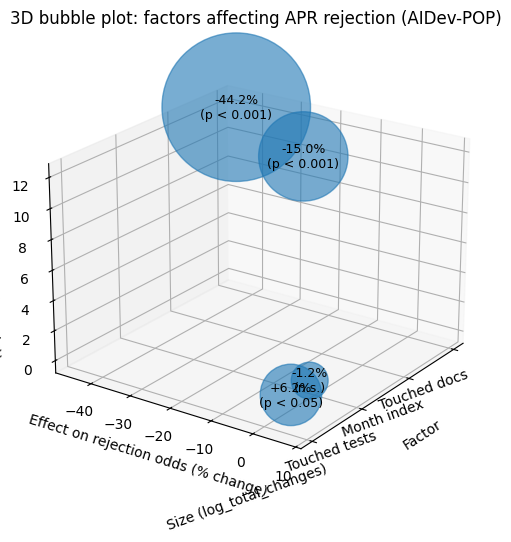

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)

# -----------------------------------
# 1. Define factors and model stats
# -----------------------------------
data = [
    {
        "factor": "Touched docs",
        "or": 0.558336,
        "p": 0.0000,
    },
    {
        "factor": "Month index",
        "or": 0.850378,
        "p": 0.0000,
    },
    {
        "factor": "Touched tests",
        "or": 0.987775,
        "p": 0.9060,
    },
    {
        "factor": "Size (log_total_changes)",
        "or": 1.062302,
        "p": 0.0180,
    },
]

df = pd.DataFrame(data)

# -----------------------------------
# 2. Derive effect (%), magnitude, significance
# -----------------------------------
df["effect_pct"] = (df["or"] - 1.0) * 100.0
df["abs_effect_pct"] = df["effect_pct"].abs()

# significance as -log10(p); for p=0, treat as very small
eps = 1e-12
df["p_adj"] = df["p"].replace(0, eps)
df["signif_score"] = -np.log10(df["p_adj"])  # higher = more significant

# bubble size: bigger & min size enforced
scale = 250.0
min_size = 400.0
df["bubble_size"] = df["abs_effect_pct"] * scale + min_size

# significance label
def sig_label(p):
    if p < 0.001:
        return "p < 0.001"
    elif p < 0.01:
        return "p < 0.01"
    elif p < 0.05:
        return "p < 0.05"
    else:
        return "n.s."

df["sig"] = df["p"].apply(sig_label)

# -----------------------------------
# 3. 3D bubble plot
# -----------------------------------
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection="3d")

# x = factor index, y = % effect, z = significance
xs = np.arange(len(df))
ys = df["effect_pct"]
zs = df["signif_score"]

sc = ax.scatter(
    xs,
    ys,
    zs,
    s=df["bubble_size"],
    alpha=0.6,
    linewidths=1.0,
)

# Axes labels
ax.set_xlabel("Factor")
ax.set_ylabel("Effect on rejection odds (% change)")
ax.set_zlabel(r"Significance ($-\log_{10}(p)$)")

# Put factor names on x-axis
ax.set_xticks(xs)
ax.set_xticklabels(df["factor"], rotation=20, ha="right")

# Horizontal plane at 0% effect for reference
# (drawn as a grid line via setting y-lim and a2D line in projection)
y_min = min(ys.min(), -5) - 5
y_max = max(ys.max(), 5) + 5
ax.set_ylim(y_min, y_max)

# Add labels near each bubble
for i, row in df.iterrows():
    label = f"{row['effect_pct']:+.1f}%\n({row['sig']})"
    ax.text(
        xs[i],
        row["effect_pct"],
        row["signif_score"],
        label,
        ha="center",
        va="center",
        fontsize=9,
    )

# Nice viewing angle
ax.view_init(elev=22, azim=35)

plt.title("3D bubble plot: factors affecting APR rejection (AIDev-POP)")
plt.tight_layout()
plt.savefig("factor_effect_3d_bubbles.pdf")
plt.show()
